## Matching and Propensity Score Matching

In [1]:
import pandas as pd
import numpy as np
import psutil
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 1.06 GB
Used Memory: 6.39 GB


In [3]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df_demeaned.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [82]:
df = pd.read_csv("./Final Data/analysis_input3.csv")
df = df.dropna(subset=['overlap'])#.dropna()

In [83]:
df['branch_closures_tract_binary'] = np.where(df['branch_closures_tract'] > 0, 1, 0)

In [120]:
df = df.dropna(subset = 'exit_overlap')

In [84]:
df_preyear = df.copy()

In [85]:
df_preyear['mergerID'].unique()

array([ 0,  5,  6,  7,  8, 11, 12, 13,  9], dtype=int64)

In [89]:
T = 'overlap' 
Y = 'branch_closures_tract_binary'

In [90]:
tract_list = ['mergerID','state','county','tract',T, Y,'medincome', 'popden', 'poptot', 'pminority',
                          'pcollege','total_branches_county','avg_branch_growth_county']

In [91]:
df_preyear = df_preyear[tract_list].dropna(subset=[Y])

In [92]:
df_preyear['mergerID'].unique()

array([ 0,  5,  6,  7,  8, 11, 12, 13,  9], dtype=int64)

In [93]:
data_with_categ = pd.concat([
    df_preyear.drop(columns='mergerID'), # dataset without the categorical features
    pd.get_dummies(df_preyear['mergerID'], columns='mergerID', prefix='merger', drop_first=False)# categorical features converted to dummies
], axis=1)

In [94]:
data_with_categ = df_preyear

In [95]:
data_with_categ

,mergerID,state,county,tract,overlap,branch_closures_tract_binary,medincome,popden,poptot,pminority,pcollege,total_branches_county,avg_branch_growth_county
0,0,36,119,4600.0,0.0,1,100382.0,10662.878788,2815.0,13.25,0.856532,253,0.040083
1,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,265,0.031748
2,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,263,0.019942
3,0,36,119,4600.0,0.0,1,100382.0,10662.878788,2815.0,13.25,0.856532,258,-0.013279
4,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,283,0.038944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13526,9,51,840,302.0,1.0,0,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.183333
13527,9,51,840,302.0,1.0,1,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.083333
13528,9,51,840,302.0,1.0,0,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.000000
13529,9,51,840,302.0,1.0,1,43750.0,2004.768392,5886.0,31.26,0.555735,11,-0.107143


In [96]:
X = data_with_categ.columns.drop(['state','county','tract',T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = df_preyear.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

In [97]:
data_ps[[T, Y, "propensity_score"]].describe()

,overlap,branch_closures_tract_binary,propensity_score
count,13531.000000,13531.000000,13531.000000
mean,0.451777,0.163476,0.464079
std,0.497688,0.369813,0.214632
min,0.000000,0.000000,0.001938
25%,0.000000,0.000000,0.272698
50%,0.000000,0.000000,0.499569
75%,1.000000,0.000000,0.646617
max,1.000000,1.000000,0.852588


In [98]:
data_ps = data_ps[~ (data_ps['propensity_score'] < 0.05) & ~ (data_ps['propensity_score'] > 0.95)]

In [99]:
weight_t = 1/data_ps.query(f"{T}==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query(f"{T}==0")["propensity_score"])
print("Original Sample Size", data_ps.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 13305
Treated Population Sample Size 12228.366340012273
Untreated Population Sample Size 13206.66496610734


C:\Users\yulon\AppData\Local\Temp\ipykernel_2472\3364425134.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ps.query(f"{T}==0")["propensity_score"], kde=False, label="Non Treated")
C:\Users\yulon\AppData\Local\Temp\ipykernel_2472\3364425134.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

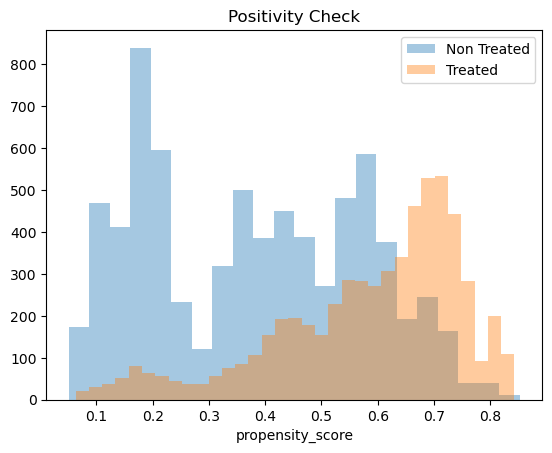

In [102]:
sns.distplot(data_ps.query(f"{T}==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query(f"{T}==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [103]:
weight = ((data_ps[T]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query(f"{T}==1")[Y]*weight_t) / len(data_ps)
y0 = sum(data_ps.query(f"{T}==0")[Y]*weight_nt) / len(data_ps)

ate = np.mean(weight * data_ps[Y])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.16753511339030205
Y0: 0.15411169526575114
ATE 0.013423418124550815


In [104]:
data_ps

,mergerID,state,county,tract,overlap,branch_closures_tract_binary,medincome,popden,poptot,pminority,pcollege,total_branches_county,avg_branch_growth_county,propensity_score
0,0,36,119,4600.0,0.0,1,100382.0,10662.878788,2815.0,13.25,0.856532,253,0.040083,0.100476
1,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,265,0.031748,0.093994
2,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,263,0.019942,0.095047
3,0,36,119,4600.0,0.0,1,100382.0,10662.878788,2815.0,13.25,0.856532,258,-0.013279,0.097727
4,0,36,119,4600.0,0.0,0,100382.0,10662.878788,2815.0,13.25,0.856532,283,0.038944,0.084974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13526,9,51,840,302.0,1.0,0,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.183333,0.714791
13527,9,51,840,302.0,1.0,1,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.083333,0.714784
13528,9,51,840,302.0,1.0,0,43750.0,2004.768392,5886.0,31.26,0.555735,14,0.000000,0.714778
13529,9,51,840,302.0,1.0,1,43750.0,2004.768392,5886.0,31.26,0.555735,11,-0.107143,0.718520


In [105]:
smf.ols(f"{Y} ~ {T}", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1526,0.004,35.324,0.000,0.144,0.161
overlap,0.0219,0.006,3.406,0.001,0.009,0.034


In [106]:
smf.ols(f"{Y} ~ {T} + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1556,0.008,19.528,0.000,0.140,0.171
overlap,0.0235,0.007,3.180,0.001,0.009,0.038
propensity_score,-0.0078,0.018,-0.441,0.659,-0.042,0.027


In [107]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [108]:
print(f"LATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

LATE: 0.37019775741304356
95% C.I.: (0.18047838812827424, 0.6125205387956347)


C:\Users\yulon\AppData\Local\Temp\ipykernel_2472\2821369219.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ates, kde=False)


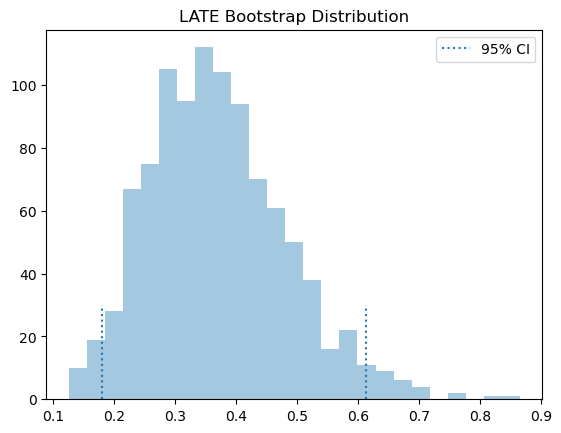

In [109]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("LATE Bootstrap Distribution")
plt.legend();